This notebook assesses the performance of the proposed method for recovering the weights in the analysis problem of GW-barycenters

Install and import packages

In [1]:
# install Python OT
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 22.6 MB/s eta 0:00:00


In [2]:
! pip install kagglehub

In [3]:
import numpy as np # linear algebra
import cv2
import pandas as pd # data processing
import scipy as sp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import time

import kagglehub

import ot

We will use Point Cloud Mnist 2D for our experiments.

In [4]:
path = kagglehub.dataset_download("cristiangarcia/pointcloudmnist2d",)

100%|██████████| 32.6M/32.6M [00:01<00:00, 29.1MB/s]

Extracting files...


In [5]:
df = pd.read_csv(path+"/test.csv")
Data = df[df.columns[1:]].to_numpy()
label = df[df.columns[0]].to_numpy()
Data = Data.reshape(Data.shape[0], -1, 3)

In [6]:
digit_indices = [np.where(label == digit)[0].tolist() for digit in range(10)]

The following function solves the GW-barycenter analysis problem.

In [7]:
def get_lambdas(matrix_temp_list, measure_temp_list, matrix_input, mesaure_input):
  '''
  get_lambdas computes the barycentric weights (lambda_1,...,lamnda_S), where S is the number of templates,
  from the simplifyed GW-Barycenter Analysis Problem by using the Lagrange Multipliers approach
  and recontruct a matrix that is "close" to a barycentric matrix
  Input:
    matrix_temp_list: list of the template matrices, that is, a list of S arrays of different dimensions (Ns,Ns),
            each one represents an (Ns x Ns) matrix that is one of the S different dissimilarity matrices of the S templates
    measure_temp_list: list of S arrays of fifferent dimensions Ns,
            each one represents a probability vector in R^Ns that is one of the S probability measures of the S templates
    matrix_input: matrix representing a dissimilarity matrix you want to analyze: (M,M) array
    measure_input: probability vector of length M (array)
  Output:
  lambdas = vector of weights, as many as number of templates: S array
            it is not guaranteed lambdas[s] >=0
  matrix_output = new synthesize matrix

  '''
  S = len(matrix_temp_list)

  pi_list = []
  F_list = []

  Q = (mesaure_input.reshape(-1,1) @ mesaure_input.reshape(1,-1))
  Q = 1. / Q

  for s in range(S):
      pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input, measure_temp_list[s], mesaure_input)
      pi_list.append(pi_s)
      F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)
      F_list.append(F_s)

  K = np.zeros((S,S))
  b = np.zeros(S)
  for i in range(S):
      b[i] = np.trace(matrix_input @ F_list[i])
      for j in range(S):
          K[i,j] = np.trace(F_list[i] @ F_list[j])

  K_aug = np.hstack([K, -0.5 * np.ones(S).reshape(-1,1)])
  last_row = np.ones(K_aug.shape[1]).reshape(1,-1)
  last_row[0,-1] = 0
  K_aug = np.vstack([K_aug,last_row])

  b_aug = np.hstack([b, [1]])

  lambdas = np.linalg.solve(K_aug, b_aug)

  lambdas = lambdas[0:-1]

  matrix_output = np.zeros_like(matrix_input)

  for s in range(S):
    matrix_output += lambdas[s] * F_list[s]
    matrix_input = matrix_output

  return matrix_output, lambdas

Get templates.

In [8]:
## Templates (matrix, measure)

digit = 3   # Pick a digit from 0 to 9

n_temp = 10   # Number of templates

ind_temp_list = []   #list of template indices from dataset
measure_temp_list = []   #list of template measures
matrix_temp_list = []   #list of template dissimilarity matrices

for s in range(n_temp):
    ind = digit_indices[digit][np.random.randint(len(digit_indices[digit]))]
    ind_temp_list.append(ind)

    p_s = Data[ind,:,2]
    valid_indices = np.where(p_s != -1)[0]
    p_s = p_s[valid_indices]
    p_s = p_s / float(p_s.sum())
    measure_temp_list.append(p_s)

    C_s = Data[ind, valid_indices, :2]
    C_s = C_s-C_s.mean(0)[np.newaxis,:]
    dist_matrix_s = sp.spatial.distance.cdist(C_s, C_s)
    matrix_temp_list.append(dist_matrix_s)

Generate vector of weights of your barycenter.


In [9]:
lambdas_list = np.random.rand(n_temp)
lambdas_list = lambdas_list/lambdas_list.sum()

Synthesize a Barycenter using POT.

In [10]:
M = 100 # Dimension of output barycentric matrix is MxM.

#b = np.ones(M) / M   # Uniform target probability vector
b = np.random.rand(M)
b = b/b.sum()   # Random target probability vector

B =  ot.gromov.gromov_barycenters(M, matrix_temp_list, measure_temp_list, b, lambdas_list)  # Synthesize barycenter matrix

Recover the vector of weights "lambdas" by only knowing the Barycenter

In [11]:
B_recon, lambdas = get_lambdas(matrix_temp_list, measure_temp_list, B, b)
print('Lambdas Error = ', np.linalg.norm(lambdas_list - lambdas, 1))

Lambdas Error =  0.42139450474183915


In [12]:
## Compare Original target vs reconstruction
gromov_distance = ot.gromov.gromov_wasserstein(B,B_recon,b,b, log=True)[1]
gw_dist = gromov_distance['gw_dist']
print(f'GW(Target,Reconstructed Target): {gw_dist}')

GW(Target,Reconstructed Target): 0.042124514479330896


In [13]:
# Sym
B = (B + B.T) / 2
B_recon = (B_recon + B_recon.T) / 2

Visualize by using MDS embedding

In [14]:
# Create an MDS instance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

In [15]:
## Fit and transform the distance matrix
points_B = mds.fit_transform(B)
points_B_recon = mds.fit_transform(B_recon)

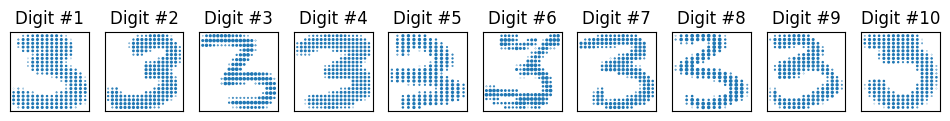

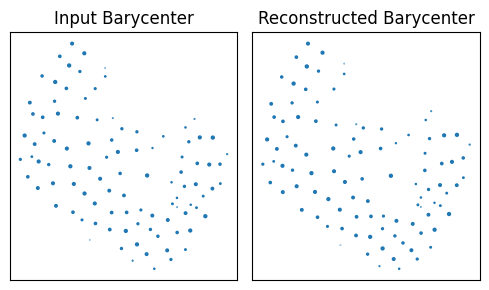

In [16]:
## Plot templates
fig, axes = plt.subplots(1, n_temp, figsize=(12, 6))
axes = axes.flatten()

for i, ind in enumerate(ind_temp_list):
    a = Data[ind,:,2]
    X = Data[ind,a!=-1,:2]
    X = X-X.mean(0)[np.newaxis,:]
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    a = a[a!=-1]
    a = a/float(a.sum())
    axes[i].scatter(X[:, 0], X[:, 1], s=a*250)
    axes[i].set_title(f'Digit #{i+1}')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_xticks([])  # Remove x-axis ticks
    axes[i].set_yticks([])  # Remove y-axis ticks
    #axes[i].axis('off')

plt.show()


## Plot Barycenter and check if it is a fix point of the iteration
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

axes[0].scatter(points_B[:, 0], points_B[:, 1], s=b*250)
axes[0].set_title('Input Barycenter')
axes[0].set_xticks([])  # Remove x-axis ticks
axes[0].set_yticks([])  # Remove y-axis ticks

axes[1].scatter(points_B_recon[:, 0], points_B_recon[:, 1], s=b*250)
axes[1].set_title('Reconstructed Barycenter')
axes[1].set_xticks([])  # Remove x-axis ticks
axes[1].set_yticks([])  # Remove y-axis ticks

# Adjust layout to avoid overlap
plt.tight_layout()

plt.show()